## Imports

In [158]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the datasets

In [159]:
routes = pd.read_csv('routes.dat', header=None)

routes.columns = ['Airline','Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

In [160]:
routes.head()

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [161]:
airports = pd.read_csv(
    'airports.dat',
    header=None,
    index_col=4,
    na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [162]:
airports.head()

,Airport ID,Name,City,Country,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TZ,Type,Source
4,,,,,,,,,,,,,
GKA,1,Goroka Airport,Goroka,Papua New Guinea,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports
MAG,2,Madang Airport,Madang,Papua New Guinea,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports
HGU,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports
LAE,4,Nadzab Airport,Nadzab,Papua New Guinea,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports
POM,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports


## Cleaning

In [163]:
airports_route = list(set(routes['Source airport']) | set(routes['Destination airport']))

In [164]:
airports_air = list(airports.index)

In [165]:
nodes = list(set(rout_air) & set(air))

In [166]:
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]

In [167]:
airports_clean = airports[airports.index.isin(nodes)]

**Save the clean data**

In [168]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## World map

**Load clean data**

In [169]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)

In [170]:
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Get edges from routes and create graph**

In [171]:
edges = routes[['Source airport', 'Destination airport']].values

In [219]:
G = nx.from_edgelist(edges)

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


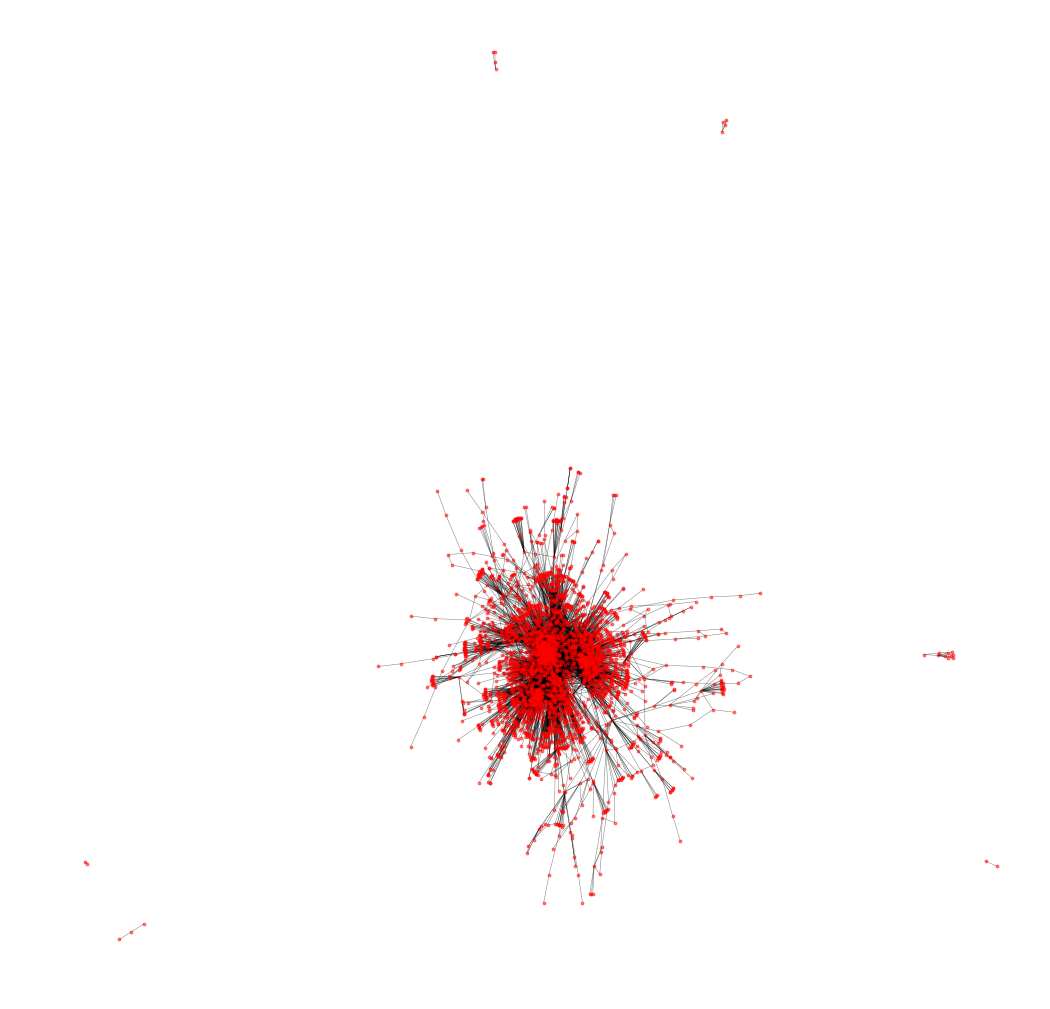

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

Get largest connected component for the rest

In [221]:
largest_cc = max(nx.connected_component_subgraphs(G), key=len)

To create the map, we first retrieve the coordinates from the airports dataframe

In [222]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [223]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Color of the nodes is the altitude

In [224]:
altitude = airports['Altitude']
altitude = [altitude[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [225]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


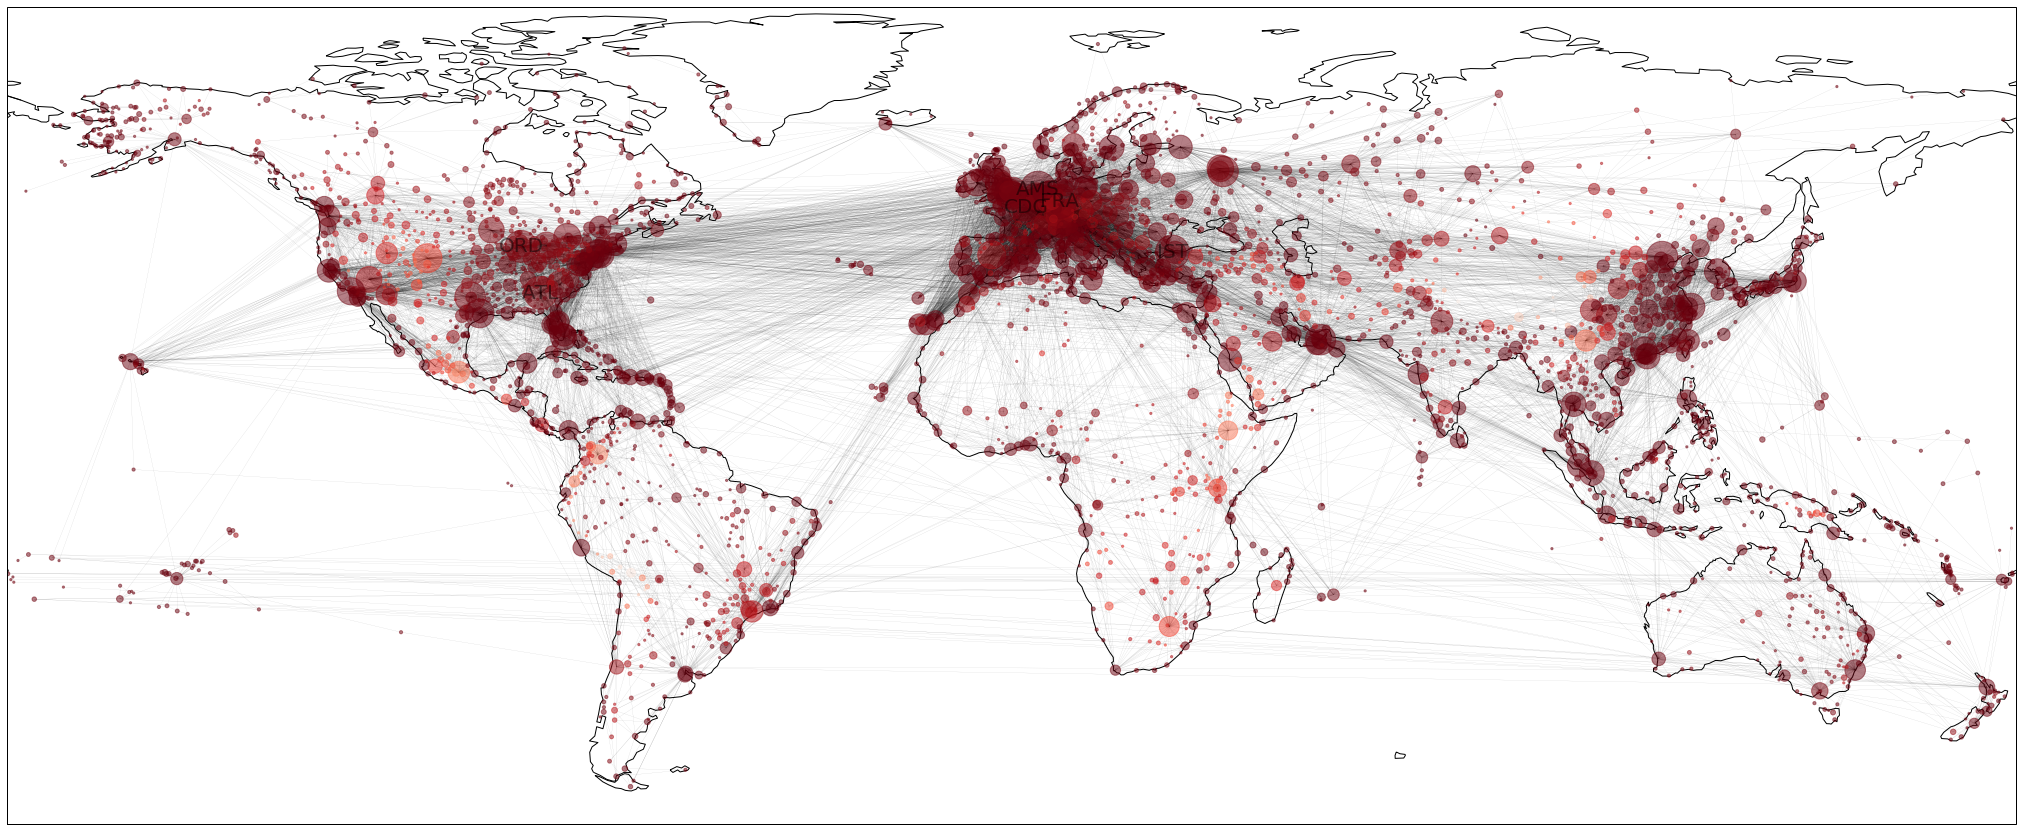

In [226]:
# Map projection
fig, ax = plt.subplots(
    1, 1, figsize=(36, 24),
    subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

# Extent of continental US.
#ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(largest_cc, ax=ax,
                 font_size=20,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                 node_color=altitude,
                 cmap=plt.cm.Reds_r)